In [1]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# *Loading the data*

In [3]:
LOCATION_CSV_TRAIN = "/content/gdrive/My Drive/Colab Notebooks/data-sea-ice/DRIFT_DATA_TRAIN.csv"
LOCATION_CSV_TEST = "/content/gdrive/My Drive/Colab Notebooks/data-sea-ice/DRIFT_DATA_TEST.csv"

In [4]:
train = pd.read_csv(LOCATION_CSV_TRAIN)
test = pd.read_csv(LOCATION_CSV_TEST)

# Marking buoy ids found in the same year & day of year

Increasing a counter to mark groups of elements respecting the conditions stated above.

***Note***:

*  We used both test and train becasue we noticed that their were days that appeared only in test. Otherwise t values wouldn't reflect the true counts.

*  This will affect the split between validation and test if we won't account for the t values that came from test. We named those `bad_ts`

In [5]:
t = 0
year_day_to_t = {}
train['t'] = 0 
test['t'] = 0
for year in sorted(list(train.year.unique())):
    for i in range(370):
        good_date = False
        if len(train[(train['year']==year) & (train['doy']==i)]) > 0:
            train.loc[(train.year==year) & (train.doy==i), 't'] = t
            good_date = True
        if len(test[(test['year']==year) & (test['doy']==i)]) > 0:
            test.loc[(test.year==year) & (test.doy==i), 't'] = t
            good_date = True
        if good_date:
            year_day_to_t[(year, i)] = t
            t += 1
            
train.head(10)

,year,month,day,doy,x_EASE,y_EASE,u_buoy,v_buoy,id_buoy,u_ERA5,v_ERA5,sic_CDR,h_cs2smos,h_piomas,d2c,t
0,1979,2,18,49,147.506958,138.582672,-0.797554,1.114740,1906,-6.704156,-0.321260,0.990195,NaN,3.189743,522.523298,0
1,1979,2,18,49,146.834778,120.509880,0.643200,0.368754,1913,-6.818630,-0.674205,0.966372,NaN,2.484009,412.767669,0
2,1979,2,18,49,130.993561,129.623672,-1.162420,0.243717,1914,-8.825469,1.123955,0.996022,NaN,2.474106,362.547379,0
3,1979,2,18,49,147.524719,157.382492,0.919766,0.025784,1918,-1.079951,-1.035410,0.982681,NaN,3.740522,381.025629,0
4,1979,2,19,50,147.470963,138.599823,0.380940,1.243485,1906,-2.169171,2.537787,0.990302,NaN,3.188522,521.535334,1
5,1979,2,19,50,180.349854,118.013527,1.387772,-0.253256,1911,2.680910,-0.295979,1.000000,NaN,2.574216,475.418633,1
6,1979,2,19,50,146.830490,120.509583,3.025445,1.076415,1913,0.551862,3.960332,1.000000,NaN,2.490376,412.761318,1
7,1979,2,19,50,130.940811,129.619873,1.409495,-0.041150,1914,-1.859920,1.140724,0.979121,NaN,2.480513,361.805709,1
8,1979,2,19,50,164.691742,110.154053,2.601760,2.154950,1925,1.245225,3.909907,0.992524,NaN,2.499613,404.686873,1
9,1979,2,20,51,197.865143,204.957596,-9.593610,-3.266865,1905,-2.742443,2.614781,0.964051,NaN,2.525601,367.538449,2


# Mapping points to a grid of various sizes

We did try various values e.g. 128, 256 but we decided the best traid off between sparsity and size was at 64

In [6]:
train['x_64'] = ((train.x_EASE * 64)/300).astype(int)
train['y_64'] = ((train.y_EASE * 64)/300).astype(int)

# Counts the number of overlaps 

Finds out the number of overlapping points in a grid cell for every grid size dimension.

We define an overlap when 2 data points have the same values for t, x_64 and y_64.


In [7]:
# counts how many overlaps we have
threshold = 5
train['overlap_64'] = train.groupby(['t', 'x_64', 'y_64']).t.transform(np.size)
print("Overlap at 64 resolution ", len(train.loc[train.overlap_64 > threshold].t.unique()))

In [8]:
train.head(2)

,year,month,day,doy,x_EASE,y_EASE,u_buoy,v_buoy,id_buoy,u_ERA5,v_ERA5,sic_CDR,h_cs2smos,h_piomas,d2c,t,x_64,y_64,overlap_64
0,1979,2,18,49,147.506958,138.582672,-0.797554,1.114740,1906,-6.704156,-0.321260,0.990195,NaN,3.189743,522.523298,0,31,29,1
1,1979,2,18,49,146.834778,120.509880,0.643200,0.368754,1913,-6.818630,-0.674205,0.966372,NaN,2.484009,412.767669,0,31,25,1


# Names of the columns we are interested in

**List of features of interest**

`year, doy, x_EASE, y_EASE, u_buoy, v_buoy, u_ERA5, v_ERA5, sic_CDR, h_piomas, d2c`



In [9]:
# used for scaling, creating the train and validation numpy 
good_columns = ['year', 'doy', 'x_EASE', 'y_EASE', 'u_buoy', 'v_buoy', 'u_ERA5', 'v_ERA5', 'sic_CDR', 'h_piomas', 'd2c']
# used to get the second input that gets fead to network
feature_2 = ['year', 'doy', 'x_EASE', 'y_EASE', 'u_ERA5', 'v_ERA5', 'sic_CDR', 'h_piomas', 'd2c']
# y we try to regress towards
outputs = ['u_buoy', 'v_buoy']

# Applies z-score for scaling the features

In [10]:
column_norm = {}
for col in good_columns:
  column_norm[col] = {
      'std': train[col].std(),
      'mean': train[col].mean(),
  }
  train[col] = (train[col] - column_norm[col]['mean'])/column_norm[col]['std']

# Creating the main dataset for training as a numpy array

In [11]:
GRID_SIZE = 64
number_ts = train.t.max()
print(f'Number of distinct t values found in dataset {number_ts}')
train_data = np.zeros((number_ts + 1, GRID_SIZE, GRID_SIZE, len(good_columns)), dtype=np.float32)

Number of distinct t values found in dataset 14590


In [12]:
for t in range(train.t.max()):
  t_train = train.loc[train.t == t]
  for _, row in t_train.iterrows():
    if row['overlap_64'] == 1:
      train_data[int(t), int(row.x_64), int(row.y_64)] = row[good_columns].to_numpy()
    else:
      overlap = t_train.loc[(row.x_64 == t_train.x_64) & (row.y_64 == t_train.y_64)][good_columns].to_numpy()
      train_data[int(t), int(row.x_64), int(row.y_64)] = np.average(overlap, axis=0)
      

In [ ]:
train_data.shape

# Creating a dataset generator

Using a dataset generator allows manipulating data in a way that allows 
extracting 2 inputs
* 1st: looks like an image with the numbe rof channels correspondent to the nmber of features we have
* 2nd: a vector of size of number of features

For the second input we want to predict the u/v_buoy



In [32]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataset, dataframe, indices, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.df = dataframe
        self.dataset = dataset
        self.indices = indices
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, batch):
        x1 = []
        x2 = []
        y = []
       
        for i, id in enumerate(batch):
          tvalues = self.df.loc[self.df.t == id]
          rr = random.randint(0, len(tvalues)-1)
          x = np.copy(self.dataset[id])
          no_overlaps = tvalues.iloc[rr].overlap_64
          if no_overlaps <= 1:
            x[int(tvalues.iloc[rr].x_64), int(tvalues.iloc[rr].y_64)] = np.zeros((11,), dtype=np.float32)
          else:
            avg_values = x[int(tvalues.iloc[rr].x_64), int(tvalues.iloc[rr].y_64)]
            t_features = tvalues.iloc[rr][good_columns].to_numpy()
            avg_values = avg_values - 1/no_overlaps * t_features
            avg_values = avg_values + 1/(no_overlaps-1) * avg_values
            x[int(tvalues.iloc[rr].x_64), int(tvalues.iloc[rr].y_64)] = avg_values

          x1.append(x)
          x2.append(tvalues.iloc[rr][feature_2])
          y.append(tvalues.iloc[rr][outputs])
          
        return [np.array(x1), np.array(x2)], np.array(y)

# Creating acrhitectures

In [34]:
def create_model_cnn_basic():
    input_1 = tf.keras.Input(shape=(64, 64, 11))
    input_2 = tf.keras.Input(shape=(9))

    conv_1 = tf.keras.layers.Conv2D(32, (16, 16), activation='sigmoid')(input_1)
    maxpool_1 = tf.keras.layers.MaxPooling2D((2, 2))(conv_1)
    bn_1 = tf.keras.layers.BatchNormalization()(maxpool_1)
    d_1 = tf.keras.layers.Dropout(0.3)(bn_1)

    conv_2 = tf.keras.layers.Conv2D(64, (4, 4), activation='relu')(d_1)
    maxpool_2 = tf.keras.layers.MaxPooling2D((2, 2))(conv_2)
    bn_2 = tf.keras.layers.BatchNormalization()(maxpool_2)
    d_2 = tf.keras.layers.Dropout(0.3)(bn_2)

    conv_3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(d_2)
    maxpool_3 = tf.keras.layers.MaxPooling2D((2, 2))(conv_3)
    bn_3 = tf.keras.layers.BatchNormalization()(maxpool_3)
    d_3 = tf.keras.layers.Dropout(0.3)(bn_3)

    flatten = tf.keras.layers.Flatten()(d_3)
    dense_1 = tf.keras.layers.Dense(64, activation='relu')(flatten)

    dense_input_2 = tf.keras.layers.Dense(64, activation='sigmoid')(input_2)
    concat = tf.keras.layers.concatenate([dense_1, dense_input_2])

    dense_2 = tf.keras.layers.Dense(64, activation='relu')(concat)
    output = tf.keras.layers.Dense(2)(dense_2)

    model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)
    
    return model, 'mean_squared_error', None

In [54]:
model, loss, loss_weights = create_model_cnn_basic()
model.compile(loss=loss, loss_weights=loss_weights, optimizer='adam')

In [ ]:
model.summary()

# Splitting into train & val

Based on indexes will split instances that will be part of train or validation set

Train: 90%

Val: 10% ~ 1400

In [36]:
# the ts that need to be accounted for in order to create a valid train/validation split
bad_ts = set(test['t'].unique()) - set(train['t'].unique())
# getting indexes for validation set
set_indexs_val = set(np.random.choice(train_data.shape[0], 1400, replace=False)) - bad_ts
indxs_val = np.array(list(set_indexs_val))
# getting indexes for train set
indxs_train = set(range(train_data.shape[0])) - set_indexs_val
indxs_train = np.array(list(indxs_train - bad_ts))

In [ ]:
train_data_gen = DataGenerator(train_data, train, indxs_train, batch_size=128, shuffle=True)
val_data_gen = DataGenerator(train_data, train, indxs_val, batch_size=128, shuffle=True)

In [ ]:
history = model.fit(train_data_gen, validation_data=val_data_gen, epochs=60, verbose=1)

# Data generators that use all the data for the final train

In [48]:
# the ts that need to be accounted for in order to create a valid train/validation split
bad_ts = set(test['t'].unique()) - set(train['t'].unique())
# getting indexes for validation set
set_indexs_all_data = set(range(train_data.shape[0])) - bad_ts
indxs_all_data = np.array(list(set_indexs_all_data))

In [52]:
all_data_gen = DataGenerator(train_data, train, indxs_all_data, batch_size=128, shuffle=True)

In [ ]:
history = model.fit(all_data_gen, epochs=60, verbose=1)

Epoch 1/60
112/112 [==============================] - 44s 390ms/step - loss: 0.9101
Epoch 2/60
112/112 [==============================] - 44s 390ms/step - loss: 0.4014
Epoch 3/60
112/112 [==============================] - 44s 389ms/step - loss: 0.3640
Epoch 4/60
112/112 [==============================] - 43s 386ms/step - loss: 0.3474
Epoch 5/60
112/112 [==============================] - 43s 386ms/step - loss: 0.3450
Epoch 6/60
112/112 [==============================] - 44s 390ms/step - loss: 0.3431
Epoch 7/60
112/112 [==============================] - 43s 388ms/step - loss: 0.3270
Epoch 8/60
112/112 [==============================] - 43s 388ms/step - loss: 0.3166
Epoch 9/60
112/112 [==============================] - 44s 390ms/step - loss: 0.3145
Epoch 10/60
112/112 [==============================] - 43s 387ms/step - loss: 0.3072
Epoch 11/60
112/112 [==============================] - 43s 387ms/step - loss: 0.3143
Epoch 12/60
112/112 [==============================] - 44s 390ms/step - lo

# Plotting training and validation curves 

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

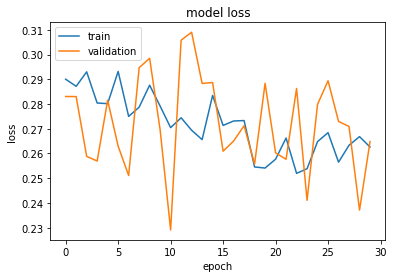

In [43]:
# summarize history for loss basic CNN
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='/content/gdrive/My Drive/Colab Notebooks/plots/model_CNN_basic.png', show_shapes=True, show_dtype=False,
    show_layer_names=False, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
# saving model
tf.keras.models.save_model(model, "/content/gdrive/My Drive/Colab Notebooks/models/sea_ice_cnn_all")

**Sanity Checks**


In [27]:
indxs_val

array([    0,  8193,  4098, ...,  8185, 12282, 12285])

In [28]:
indxs_val[4:20]

array([12295,  4112, 12305,  4113, 12308,  4117,    22,  4116,    25,
          28, 12316,    30,  8227, 12327,  8232,  4137])

In [29]:
to_test = 0
conv_input = np.copy(train_data[to_test])
buoy = train[train['t']==to_test].iloc[0]
conv_input[int(buoy['x_64']), int(buoy['y_64'])] = np.zeros((11))
feature_input = np.array(buoy[feature_2])
buoy[outputs]

u_buoy   -0.057543
v_buoy   -0.031163
Name: 0, dtype: float64

In [31]:
model.predict([np.array([conv_input]), np.array([feature_input])])[0]

array([[-0.4903034, -0.3448881]], dtype=float32)